In [1]:
import utilities_geopandas as ugp

In [4]:
import matplotlib as mpl

In [7]:
mpl.rcParams.update({'font.size': 20})

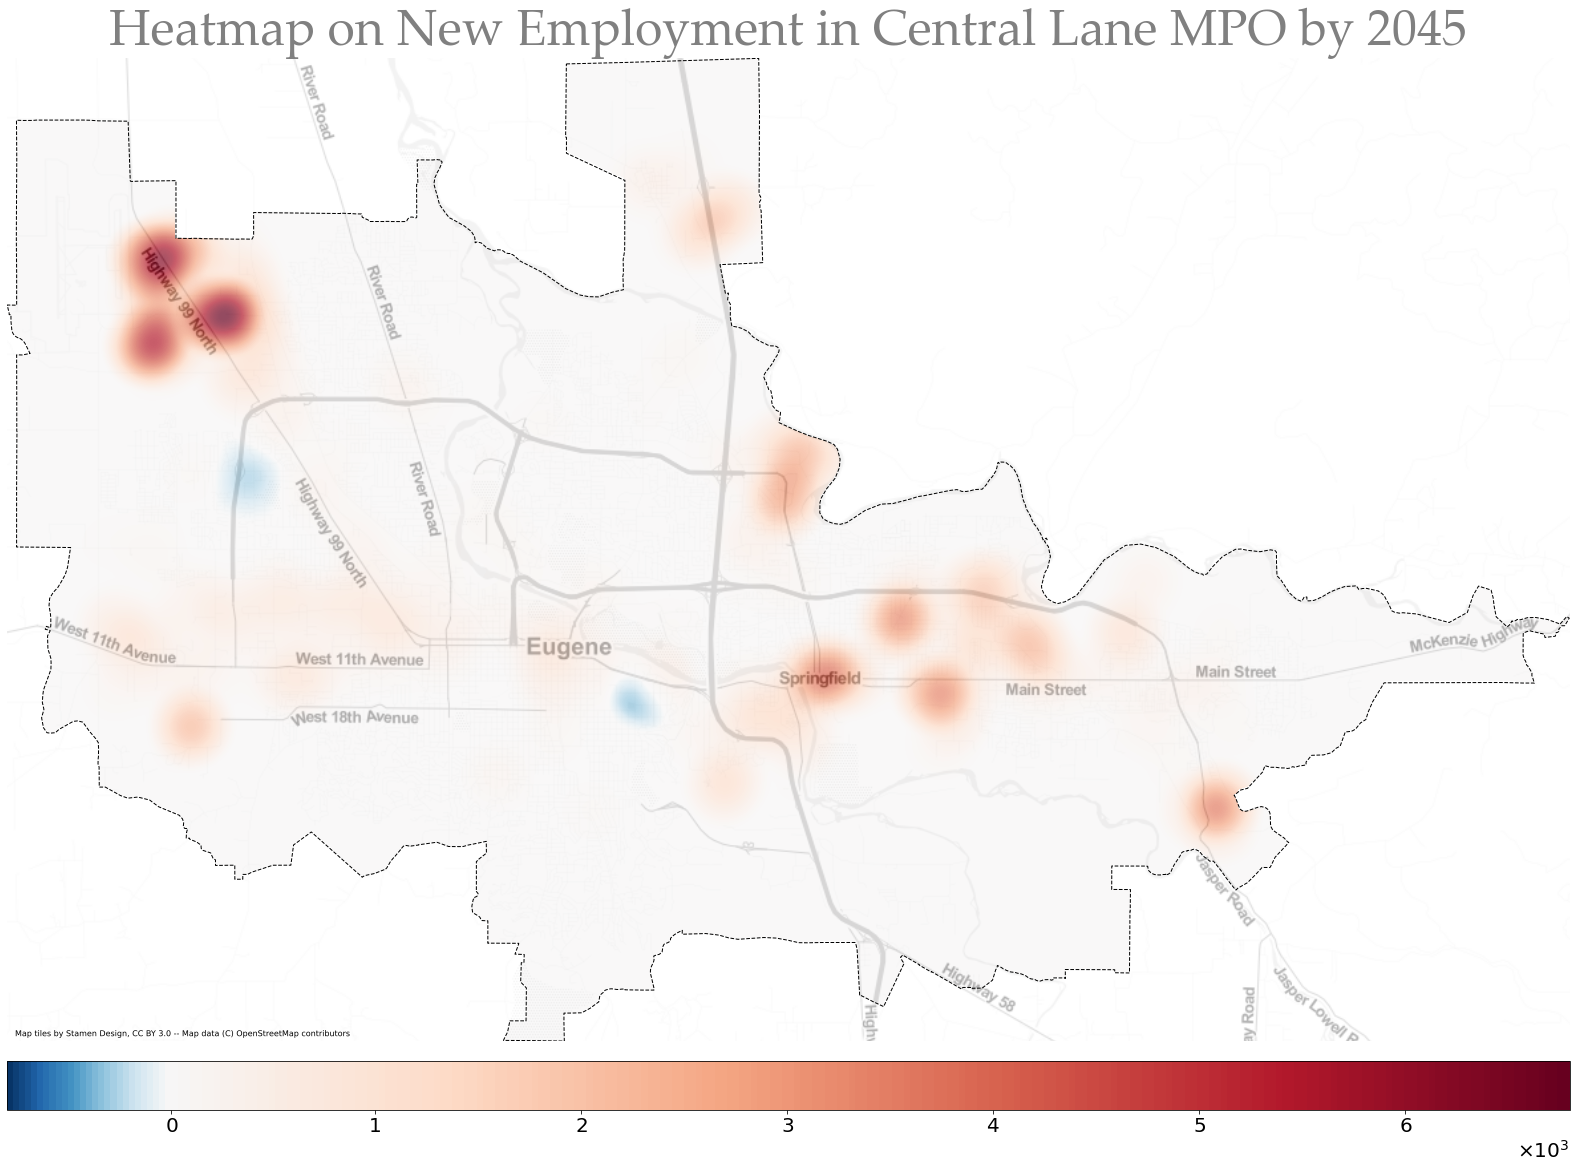

In [8]:
ugp.plotRaster(yrbuilt = 2045, colormap = 'RdBu_r', export = False)

In [1]:
import geopandas as gpd
import os

In [2]:
# source: https://github.com/dongmeic/RTP/blob/main/analysis/process_parcel_data.ipynb
path = r'T:\Trans Projects\Model Development\UrbanSim_LandUse\Output\Simulation_47_Final_RTP'
shp = 'parcel_fabric.shp'

In [6]:
parcel_data = gpd.read_file(os.path.join(path, shp))

In [4]:
parcel_data.columns

Index(['btype', 'nrsqft', 'rsqft', 'du', 'yrbuilt', 'lpid', 'pundev',
       'dev_land', 'developed', 'obtype', 'orsqft', 'onrsqft', 'odu', 'zid',
       'rezoned', 'city', 'annexed', 'ozid', 'geometry'],
      dtype='object')

In [5]:
parcel_data['AreaPerJob'] = parcel_data['btype'].apply(lambda x: ugp.area_per_job(x)[0])

In [6]:
parcel_data['isNonRes'] = parcel_data['btype'].apply(lambda x: ugp.area_per_job(x)[1])

In [7]:
parcel_data['jobs'] = parcel_data.apply(lambda row: ugp.compute_jobs(row['isNonRes'],
                                                                     row['nrsqft'], row['AreaPerJob']), axis=1)
parcel_data['ojobs'] = parcel_data.apply(lambda row: ugp.compute_jobs(row['isNonRes'], 
                                                                      row['onrsqft'], row['AreaPerJob']), axis=1)

In [8]:
parcel_data['ndu'] = parcel_data['du'] - parcel_data['odu']
parcel_data['nnrsqft'] = parcel_data['nrsqft'] - parcel_data['onrsqft']

In [9]:
parcel_data['njobs'] = parcel_data.apply(lambda row: ugp.compute_jobs(row['isNonRes'], 
                                                                      row['nnrsqft'], row['AreaPerJob']), axis=1)

In [10]:
parcel_data['hh'] = parcel_data['du'].apply(lambda x: x*0.965)
parcel_data['ohh'] = parcel_data['odu'].apply(lambda x: x*0.965)
parcel_data['nhh'] = parcel_data['ndu'].apply(lambda x: x*0.965)

In [11]:
parcel_data = parcel_data.to_crs(epsg=3857)

In [12]:
parcel_data.to_file(os.path.join(path, 'output', 'parcel_data.shp'))

In [13]:
parcel_data.njobs.describe()

count    3924.000000
mean       23.833784
std       169.225725
min      -834.036279
25%         0.000000
50%         0.000000
75%         4.779313
max      6069.996603
Name: njobs, dtype: float64

for yrbuilt in range(2021, 2046, 1):
    ugp.splitData(yrbuilt = yrbuilt)
    ugp.splitData(yrbuilt = yrbuilt, by = 'yearly')  

In [4]:
import utilities_propy as upp

for yrbuilt in range(2021, 2046, 1): 
    upp.spatialJoin(yrbuilt = yrbuilt, by = 'yearly')

for yrbuilt in range(2021, 2046, 1): 
    for field in ["njobs", "nhh"]: 
        upp.createHeatmap(yrbuilt, field = field)

In [3]:
yrbuilt = 2045
field = "njobs"
fieldName = 'Employment'

In [4]:
colormap = 'RdYlBu_r'

In [5]:
import os, glob
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.ticker import ScalarFormatter
import rasterio
import fiona
from rasterio.plot import show, show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
vmin = ugp.getMinMax()[0]

In [10]:
vmax = ugp.getMinMax()[1]

In [11]:
file = os.path.join(path, 'output', "KernelD_" + field + "_" + str(yrbuilt) + ".tif")

In [12]:
src = rasterio.open(file)

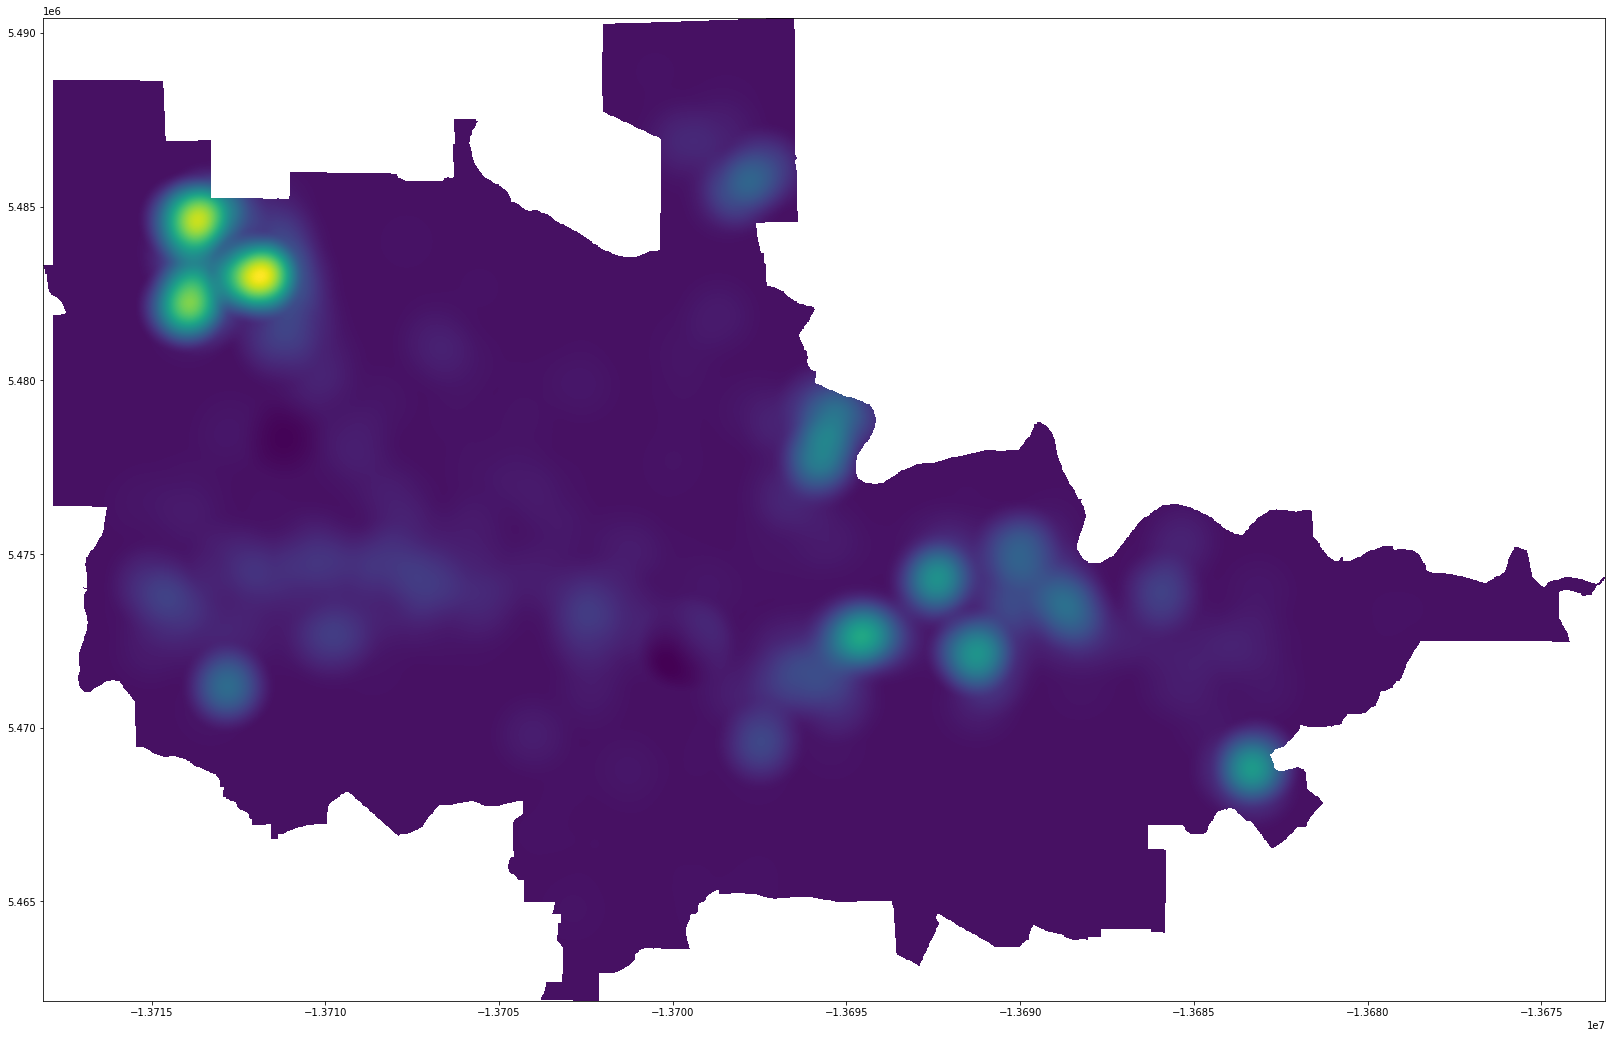

<AxesSubplot:>

In [27]:
fig, ax = plt.subplots(1, figsize=(28, 24))
show(src)

In [13]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Bound.shp")

In [14]:
from matplotlib import colors

In [15]:
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

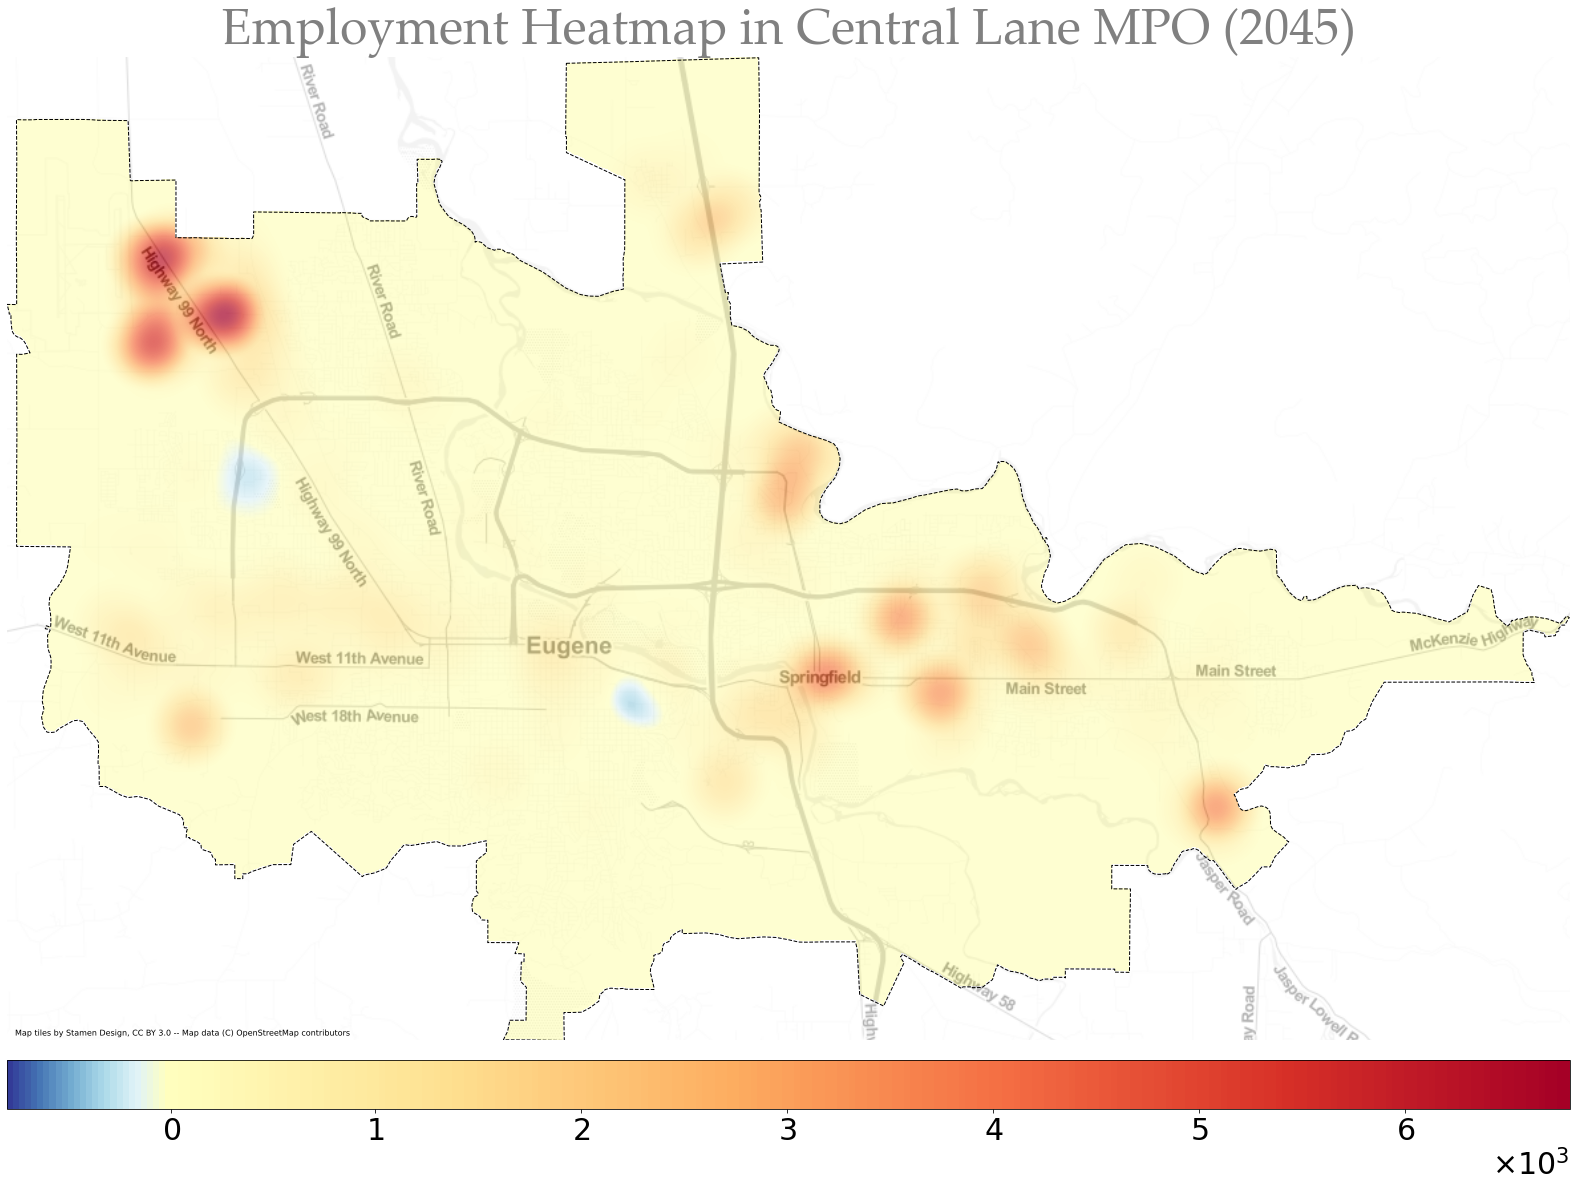

In [17]:
fig, ax = plt.subplots(figsize=(28, 24))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad="2%")

# plot on the same axis with rio.plot.show
data = src.read(1)
ndata = np.where(data == data.min(), np.nan, data)

data_ex = data[data != data.min()]
image = show(ndata, 
                 transform=src.transform, 
                 ax=ax, #alpha=0.7,
                 cmap=colormap,
                 norm=norm)

MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, alpha=0.3)
ax.set_title(fieldName + " Heatmap in Central Lane MPO (" + str(yrbuilt) + ")", fontsize=50, fontname="Palatino Linotype", 
                  color="grey", loc = 'center')

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(ndata, 
                         cmap=colormap,
                         norm=norm)    

fmt = mpl.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cbar = plt.colorbar(image_hidden, format=fmt, ax=ax, cax=cax, orientation="horizontal")

ax.axis("off");

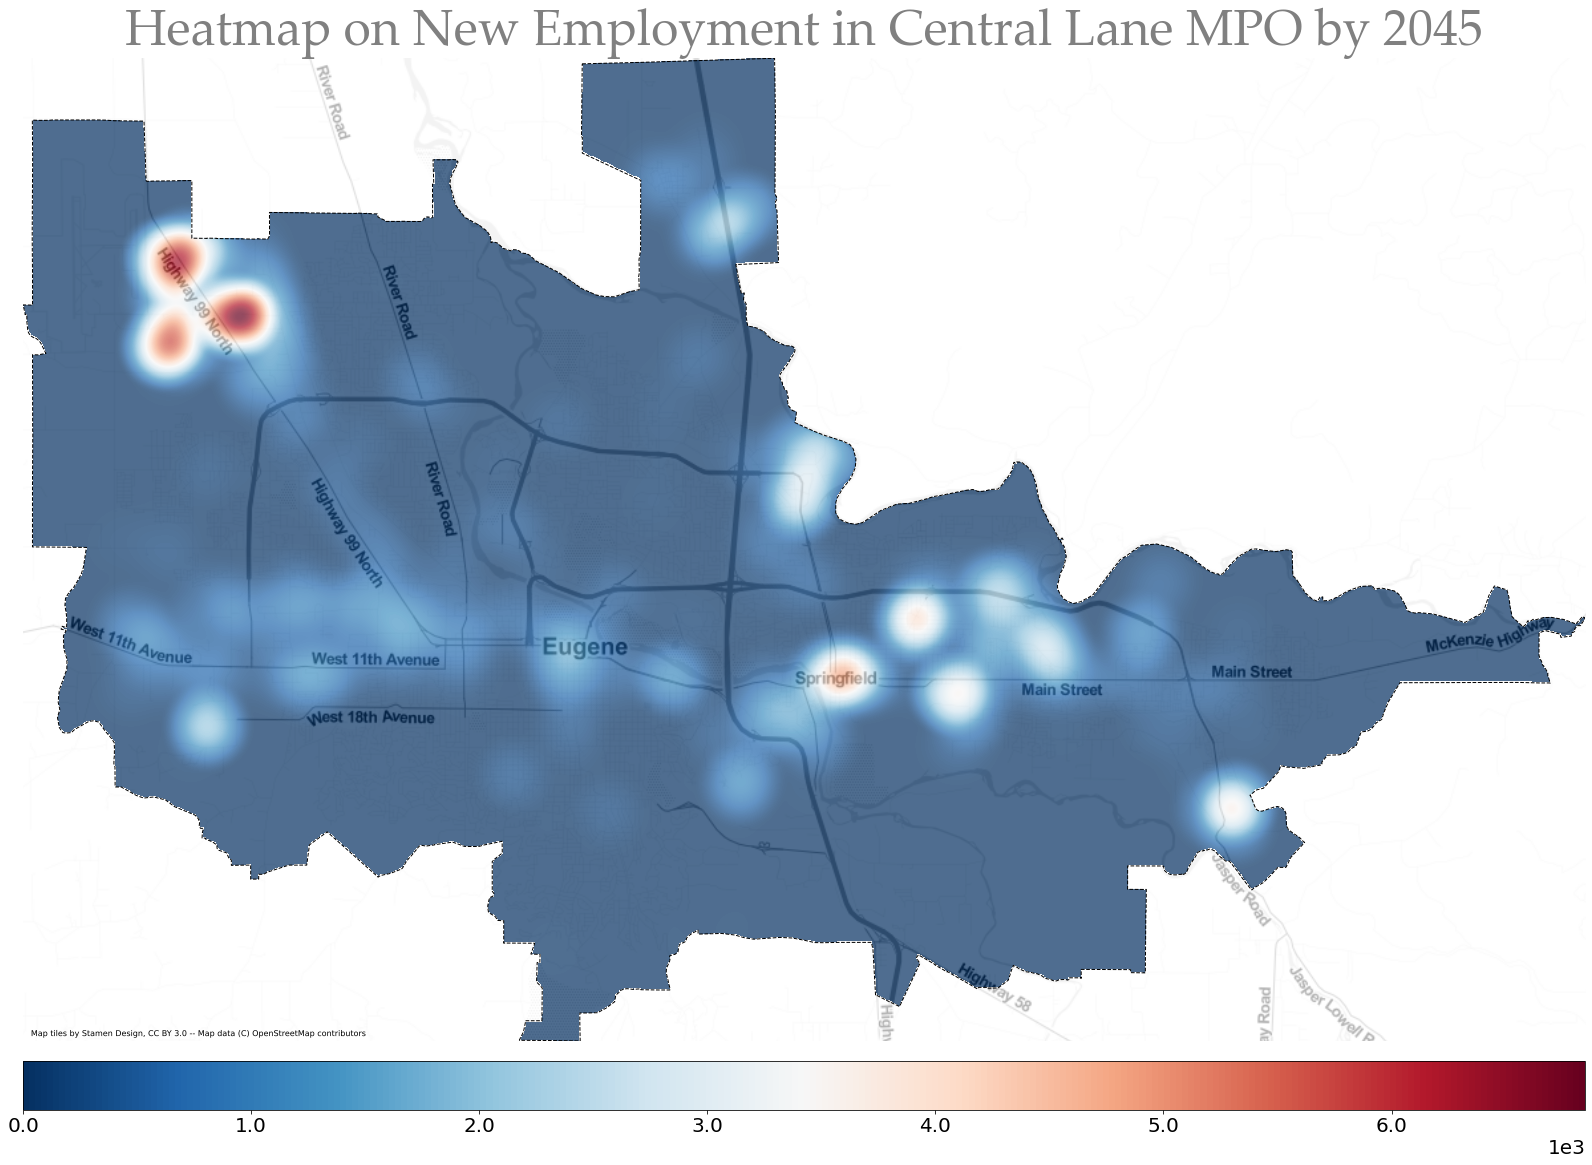

In [17]:
ugp.plotRaster(yrbuilt = 2045, export = False)